In [1]:
import numpy as np 
from shapely.geometry import Polygon,Point,LineString
import geopandas as gpd 
import Environment
import matplotlib.pyplot as plt
import random
import queue

def deal_shp(path):
    grid_shp=gpd.read_file(path)
    
    grid_shp['centroid_x']=grid_shp.centroid.x
    grid_shp['centroid_y']=grid_shp.centroid.y 
    grid_shp['centroid_x']=grid_shp['centroid_x'].apply(lambda x: round(x,5))
    grid_shp['centroid_y']=grid_shp['centroid_y'].apply(lambda x: round(x,5))
    
    yvalues=np.unique(grid_shp['centroid_y'].values)
    yvalues.sort()
    xvalues=np.unique(grid_shp['centroid_x'].values)
    xvalues.sort()
    
    widthx=round((xvalues[1]-xvalues[0]),5)
    widthy=round((yvalues[1]-yvalues[0]),5)
    print (widthx,widthy)
    xmin=xvalues.min()-widthx/2
    ymin=yvalues.min()-widthy/2
    
    lx=len(xvalues)
    ly=len(yvalues)
    grid_shp['x']=(grid_shp['centroid_x'].apply(lambda x:round((x-widthx/2-xmin)/widthx)))
    grid_shp['y']=(grid_shp['centroid_y'].apply(lambda x:round((x-widthy/2-ymin)/widthy)))
    grid_shp=grid_shp.set_index(['x','y'],drop=False)
    return grid_shp,lx,ly,widthx,widthy,xmin,ymin

In [2]:
def init_environment_from_shp(grid_shp,lx,ly,widthx,widthy,minx,miny):
    Envir=Environment.Environment(lx,ly,widthx,widthy,minx,miny)
    flag_matrix=Envir.get_flagmap()
    empty_matrix=np.zeros([lx,ly])
    for y in range(ly):
        for x in range(lx):
            empty_matrix[x][y]=grid_shp.loc[(x,y),'popsum']
    # plt.imshow(empty_matrix)
    Envir.set_gridValue(empty_matrix)
    # grid_shp.plot(column='popsum')
    # plt.show()
    print ('OK')
    return Envir

In [3]:
def get_random_grid(Envir,D_star):
    grid_list=Envir.get_empty_gridlist()
    grid_list=[item for item in grid_list if item.pop>D_star]
    if (len(grid_list)>0):
        grid=random.choice(grid_list)
    else:
        grid=None
    return grid

In [4]:
def CCA_expand(Envir,D_star):
    Q=queue.Queue(maxsize=-1)
    flag=1
    while (True):
        if (Q.empty()):
            temp_grid=get_random_grid(Envir,D_star)
            if(temp_grid==None):
                break
            Envir.gridDict[(temp_grid.x,temp_grid.y)].flag=flag
            temp_grid.flag=flag
            flag+=1
        else:
            temp_grid=Q.get()

        neighbors=Envir.get_neighbors(temp_grid.x,temp_grid.y)
        for neighbor in neighbors:
            if(neighbor.flag>=0):
                continue
            if(neighbor.pop<D_star):
                continue
            Envir.gridDict[(neighbor.x,neighbor.y)].flag=temp_grid.flag
            neighbor.flag=temp_grid.flag
            Q.put(neighbor)
    return Envir

In [24]:
shp_path=r'D:\wangyx\spatialYule\Grid\JZH_1000_WGS84.shp'
grid_shp,lx,ly,widthx,widthy,xmin,ymin=deal_shp(shp_path)
Envir=init_environment_from_shp(grid_shp,lx,ly,widthx,widthy,xmin,ymin)

0.00833 0.00833
OK


In [29]:
import copy
population_threshold=[500,1000,2500,5000,10000]
Envir_list=[]
for threshold in population_threshold:
    temp_Envir=copy.deepcopy(Envir)
    temp_Envir=CCA_expand(Envir=temp_Envir,D_star=threshold)
    Envir_list.append(temp_Envir)
    print (threshold)

500
1000
2500
5000
10000


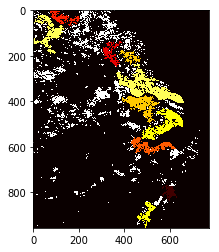

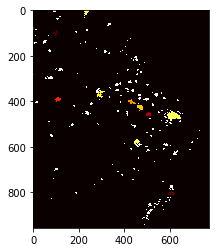

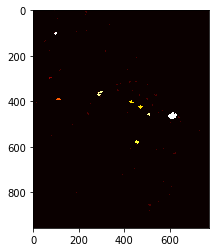

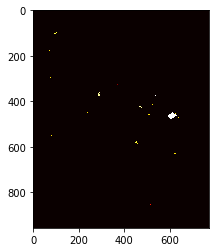

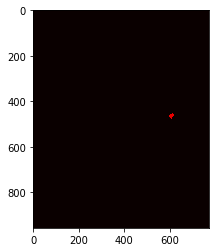

In [180]:
for temp_Envir in Envir_list:
    flag_matrix=temp_Envir.get_flagmap()
    
    flag_array=flag_matrix.flatten()
    flag,flag_count=np.unique(flag_array,return_counts=True)
    flag,flag_count=flag[:-1],flag_count[:-1]
    indexs=np.argsort(flag_count)[-11:]
    special_flag=flag[indexs]
    flag_matrix[~np.isin(flag_matrix, special_flag)]=11
    
    index = np.argwhere(special_flag==-1)
    special_flag=np.delete(special_flag,index)
    
    for index,flag in enumerate(special_flag):
        flag_matrix[flag_matrix==flag]=index

    flag_matrix=np.rot90(flag_matrix,1)
    plt.imshow(flag_matrix,cmap='hot')
    plt.show()

Text(0, 0.5, 'Population (normalized)')

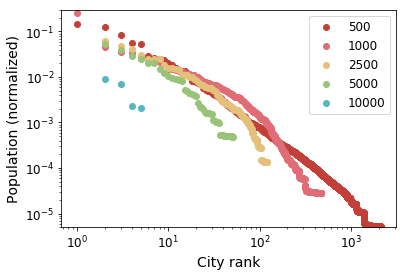

In [121]:
colors=['#c24038','#e06c75','#e5c07b','#98c379','#56b6c2','#61afef','#c678dd']
labels=[500,1000,2500,5000,10000]
for index,temp_Envir in enumerate(Envir_list):
    popdict=temp_Envir.get_Gridpop_distribution()
    
    poplist=[]
    for keys in  popdict:
        poplist.append(popdict[keys])
    poplist.sort(reverse=True)
    poplist=np.array(poplist[1:])
    poplist=poplist/sum(poplist)
    step=list(range(1,len(poplist)+1))
    plt.scatter(step,poplist,c=colors[index],label=labels[index])
plt.ylim(0.000005,0.3)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlabel('City rank',fontsize=14)
plt.ylabel('Population (normalized)',fontsize=14)

## get the cities areas

Text(0, 0.5, 'Area (normalized)')

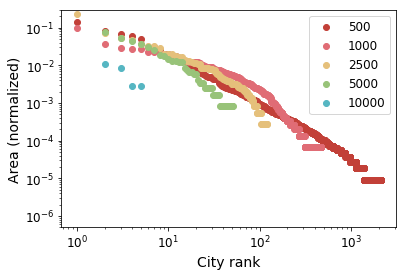

In [118]:
for index,temp_Envir in enumerate(Envir_list):
    flag_matrix=temp_Envir.get_flagmap()
    flag_array=np.array(flag_matrix).flatten()
    flag,flag_count=np.unique(flag_array,return_counts=True)
    flag_count=list(flag_count[1:])
    flag_count.sort(reverse=True)
    flag_count=np.array(flag_count)/sum(flag_count)
    step=list(range(1,len(flag_count)+1))
    plt.scatter(step,flag_count,c=colors[index],label=labels[index])
    
plt.ylim(0.0000005,0.3)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlabel('City rank',fontsize=14)
plt.ylabel('Area (normalized)',fontsize=14)

In [122]:
def get_popdensity(Envir):
    grid_dict=Envir.gridDict
    flag_dict={}
    for key in grid_dict:
        temp_flag=grid_dict[key].flag
        temp_pop=grid_dict[key].pop
        if(temp_flag in flag_dict):
            flag_dict[temp_flag][0]+=temp_pop
            flag_dict[temp_flag][1]+=1
        else:
            flag_dict[temp_flag]=[temp_pop,1]
    return flag_dict

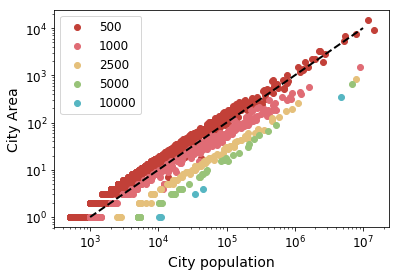

In [141]:
for index,temp_environment in enumerate(Envir_list):
    flag_dict=get_popdensity(temp_environment)
    pop_list=[]
    area_list=[]
    for key in flag_dict.keys():
        if(key==-1):
            continue
        pop_list.append(flag_dict[key][0])
        area_list.append(flag_dict[key][1])
    density_list=np.array(pop_list)/np.array(area_list)
    plt.scatter(pop_list,area_list,c=colors[index],label=labels[index])
# plt.xlim(0,5,10**5)
# plt.ylim(100,10**5)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlabel('City population',fontsize=14)
plt.ylabel('City Area',fontsize=14)
plt.plot([1000,10000000],[1,10000],c='#000000',linewidth=2,linestyle='--')

[13686.8575156  11022.35020924 11165.73077941 11600.9870491
 10327.18824768]


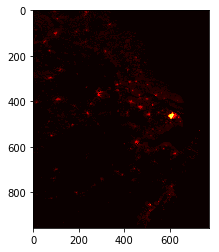

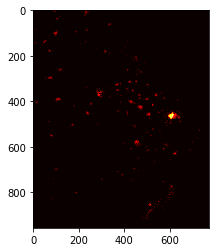

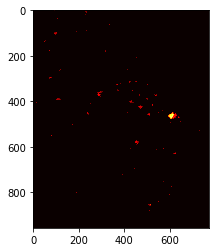

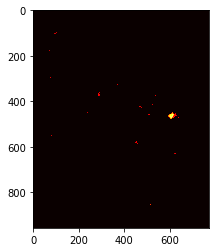

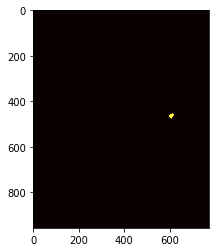

In [148]:
for temp_enviroment in Envir_list:
    pop_map=temp_enviroment.get_popmap()
    flag_map=temp_enviroment.get_flagmap()
    flag_map[flag_map>=0]=1
    flag_map[flag_map<0]=0
    pop_map2=pop_map*flag_map
    pop_map2=np.rot90(pop_map2,1)
    plt.imshow(pop_map2,cmap='hot')
    plt.show()